#####   
# Recommendation System by KNN (Content-Based Filtering)
 - Purpose: Making a recommender to suggest movies

# 1) Loading Libraries

In [56]:
import numpy   as np
import pandas  as pd
import seaborn as sns
from   matplotlib import pyplot as plt

pd.set_option('display.max_rows'   ,2000)
pd.set_option('display.max_columns', 500)

# display results to 3 decimal points, not in scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x) 

import gc
from   scipy.sparse import csr_matrix

#####   
# 2) Loading and Exploring the Data

In [5]:
df1 = pd.read_csv('movies.csv')
df1.tail(3)

,movieId,title,genres
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation
9741,193609,Andrew Dice Clay: Dice Rules (1991),Comedy


In [8]:
df2 = pd.read_csv('ratings.csv')
df2.tail(3)

,userId,movieId,rating,timestamp
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352
100835,610,170875,3.0,1493846415


In [9]:
df1 = df1[['movieId','title']]
df1.tail(3)

,movieId,title
9739,193585,Flint (2017)
9740,193587,Bungo Stray Dogs: Dead Apple (2018)
9741,193609,Andrew Dice Clay: Dice Rules (1991)


In [10]:
df2 = df2[['userId','movieId','rating']]
df2.tail(3)

,userId,movieId,rating
100833,610,168250,5.0
100834,610,168252,5.0
100835,610,170875,3.0


In [16]:
df_Merged = pd.merge( df2, df1, how='left', on='movieId' ).drop('movieId',axis=1)
print( df_Merged.shape )
df_Merged.tail(3)

(100836, 3)


,userId,rating,title
100833,610,5.0,Get Out (2017)
100834,610,5.0,Logan (2017)
100835,610,3.0,The Fate of the Furious (2017)


# dropping duplicates

In [17]:
df_Merged.drop_duplicates( inplace=True )

# dropping null values

In [22]:
if df_Merged['title'].isnull().sum() > 0:
    df_Merged = df_Merged.dropna( axis=0, subset=['title'] )
df_Merged.isnull().sum()

userId    0
rating    0
title     0
dtype: int64

# Groups

In [26]:
G1 = df_Merged.groupby('userId')['title'].count().sort_values(ascending=False).reset_index()
G1 = G1.rename( columns = { 'title' : 'userId_count' } )
G1.head(3)

,userId,userId_count
0,414,2698
1,599,2478
2,474,2108


In [37]:
G2 = df_Merged.groupby('title')['userId'].count().sort_values(ascending=False).reset_index()
G2 = G2.rename( columns = { 'userId' : 'title_count' } )
G2.head(3)

,title,title_count
0,Forrest Gump (1994),329
1,"Shawshank Redemption, The (1994)",317
2,Pulp Fiction (1994),307


In [38]:
G3 = df_Merged.groupby('title')['rating'].sum().sort_values(ascending=False).reset_index()
G3 = G3.rename( columns = { 'rating' : 'rating_sum' } )
G3.head(3)

,title,rating_sum
0,"Shawshank Redemption, The (1994)",1404.0
1,Forrest Gump (1994),1370.0
2,Pulp Fiction (1994),1288.5


In [39]:
G4 = df_Merged.groupby('title')['rating'].median().sort_values(ascending=False).reset_index()
G4 = G4.rename( columns = { 'rating' : 'rating_median' } )
G4.head(3)

,title,rating_median
0,"Story of Women (Affaire de femmes, Une) (1988)",5.0
1,Mother (Madeo) (2009),5.0
2,George Carlin: Back in Town (1996),5.0


#####   
# 3) Adding Columns

In [40]:
df = df_Merged.copy()
df = pd.merge( df, G1, how='left', on='userId' )
df = pd.merge( df, G2, how='left', on='title'  )
df = pd.merge( df, G3, how='left', on='title'  )
df = pd.merge( df, G4, how='left', on='title'  )
df.head(3)

,userId,rating,title,userId_count,title_count,rating_sum,rating_median
0,1,4.0,Toy Story (1995),232,215,843.0,4.0
1,1,4.0,Grumpier Old Men (1995),232,52,169.5,3.0
2,1,4.0,Heat (1995),232,102,402.5,4.0


In [47]:
df = df[ ['userId', 'userId_count', 'rating', 'rating_median', 'rating_sum', 'title', 'title_count'] ]
df = df.sort_values(['title_count','rating_sum','rating_median','userId_count'],ascending=[False,False,False,False])
df.head(3)

,userId,userId_count,rating,rating_median,rating_sum,title,title_count
62452,414,2698,5.0,4.0,1370.0,Forrest Gump (1994),329
92766,599,2478,3.5,4.0,1370.0,Forrest Gump (1994),329
73188,474,2108,3.0,4.0,1370.0,Forrest Gump (1994),329


In [48]:
del G1, G2, G3, G4

#####   
# 5) EDA 

In [57]:
def BoxPlot(df,ft):
    boxprops    = dict( edgecolor = 'k', facecolor  = 'cyan', linewidth = 1 )
    medianprops = dict( color     = 'k', linewidth  = 1  )
    flierprops  = dict( marker    = 'd', markersize = 7, markerfacecolor = 'red', markeredgecolor = 'red' ) 
                  
    plt.figure(  figsize=(3,1)  )
    sns.boxplot( x=df[ft]
               , boxprops    = boxprops
               , medianprops = medianprops
               , flierprops  = flierprops  
               )
    plt.title(ft)
    plt.xlabel('') 
    plt.show()

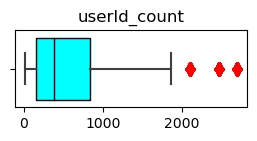

count   100833.000
mean       603.877
std        653.018
min         20.000
25%        148.000
50%        385.000
75%        836.000
max       2698.000
Name: userId_count, dtype: float64

In [58]:
ft = 'userId_count'
BoxPlot(df,ft)
df[ft].describe()

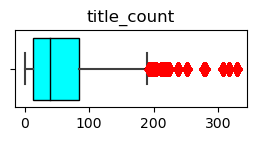

count   100833.000
mean        58.759
std         61.966
min          1.000
25%         13.000
50%         39.000
75%         84.000
max        329.000
Name: title_count, dtype: float64

In [59]:
ft = 'title_count'
BoxPlot(df,ft)
df[ft].describe()

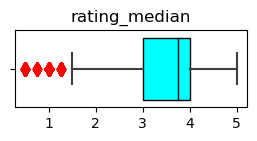

count   100833.000
mean         3.572
std          0.614
min          0.500
25%          3.000
50%          3.750
75%          4.000
max          5.000
Name: rating_median, dtype: float64

In [60]:
ft = 'rating_median'
BoxPlot(df,ft)
df[ft].describe()

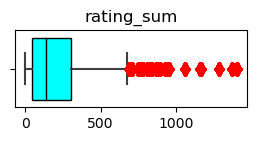

count   100833.000
mean       219.795
std        251.535
min          0.500
25%         43.000
50%        135.500
75%        300.500
max       1404.000
Name: rating_sum, dtype: float64

In [61]:
ft = 'rating_sum'
BoxPlot(df,ft)
df[ft].describe()

# Keeping only top titles (where no of rates are more)


In [156]:
DF = df.copy()
n  = 3

threshold1 = DF['rating_sum'].quantile(.25)/n
threshold2 = DF['rating_sum'].min()
threshold  = max( threshold1, threshold2 )
DF = DF.query( 'rating_sum > @threshold' )

threshold1 = DF['rating_median'].quantile(.25)/n
threshold2 = DF['rating_median'].min()
threshold  = max( threshold1, threshold2 )
DF = DF.query( 'rating_median > @threshold' )

threshold1 = DF['userId_count'].quantile(.25)/n
threshold2 = DF['userId_count'].min()
threshold  = max( threshold1, threshold2 )
DF = DF.query( 'userId_count > @threshold' )

threshold1 = DF['title_count'].quantile(.25)/n
threshold2 = DF['title_count'].min()
threshold  = max( threshold1, threshold2 )
DF = DF.query( 'title_count > @threshold' )

print( DF.shape )
print( DF['title'].nunique() )
DF.head(3)

(80188, 7)
2933


,userId,userId_count,rating,rating_median,rating_sum,title,title_count
62452,414,2698,5.000,4.000,1370.000,Forrest Gump (1994),329
92766,599,2478,3.500,4.000,1370.000,Forrest Gump (1994),329
73188,474,2108,3.000,4.000,1370.000,Forrest Gump (1994),329


#####   
# 6) Pivot Table
 - Making **Pivot Table** of **Title** & **Rating**

In [157]:
# Making the Pivot Table of Title & Rating
df_Pivot      = DF.pivot_table(index='userId',columns='title',values='rating')
df_Pivot_Zero = df_Pivot.copy().fillna(0)
df_Pivot_Zero.tail()

title,"'burbs, The (1989)",(500) Days of Summer (2009),*batteries not included (1987),10 Cloverfield Lane (2016),10 Things I Hate About You (1999),"10,000 BC (2008)",101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),102 Dalmatians (2000),12 Angry Men (1957),12 Years a Slave (2013),127 Hours (2010),13 Going on 30 (2004),"13th Warrior, The (1999)",1408 (2007),15 Minutes (2001),16 Blocks (2006),17 Again (2009),1984 (Nineteen Eighty-Four) (1984),2 Days in the Valley (1996),"2 Fast 2 Furious (Fast and the Furious 2, The) (2003)",20 Dates (1998),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),2010: The Year We Make Contact (1984),2012 (2009),2046 (2004),21 (2008),21 Grams (2003),21 Jump Street (2012),22 Jump Street (2014),24 Hour Party People (2002),25th Hour (2002),27 Dresses (2008),28 Days (2000),28 Days Later (2002),28 Weeks Later (2007),30 Days of Night (2007),300 (2007),3000 Miles to Graceland (2001),"39 Steps, The (1935)",3:10 to Yuma (2007),40 Days and 40 Nights (2002),"40-Year-Old Virgin, The (2005)","400 Blows, The (Les quatre cents coups) (1959)",47 Ronin (2013),48 Hrs. (1982),50 First Dates (2004),50/50 (2011),"6th Day, The (2000)",8 1/2 (8½) (1963),8 Mile (2002),8MM (1999),9 (2009),9 1/2 Weeks (Nine 1/2 Weeks) (1986),A Million Ways to Die in the West (2014),"A-Team, The (2010)",A.I. Artificial Intelligence (2001),AVP: Alien vs. Predator (2004),About Last Night... (1986),About Schmidt (2002),About Time (2013),About a Boy (2002),"Absent-Minded Professor, The (1961)",Absolute Power (1997),"Abyss, The (1989)",Accepted (2006),Ace Ventura: Pet Detective (1994),Ace Ventura: When Nature Calls (1995),Across the Universe (2007),Adaptation (2002),Addams Family Values (1993),"Addams Family, The (1991)",Addicted to Love (1997),"Adjustment Bureau, The (2011)",Adventureland (2009),Adventures in Babysitting (1987),"Adventures of Baron Munchausen, The (1988)","Adventures of Buckaroo Banzai Across the 8th Dimension, The (1984)","Adventures of Milo and Otis, The (Koneko monogatari) (1986)","Adventures of Priscilla, Queen of the Desert, The (1994)","Adventures of Robin Hood, The (1938)","Adventures of Rocky and Bullwinkle, The (2000)","Adventures of Tintin, The (2011)",Aeon Flux (2005),"Affair to Remember, An (1957)","African Queen, The (1951)",After Hours (1985),"Age of Innocence, The (1993)","Aguirre: The Wrath of God (Aguirre, der Zorn Gottes) (1972)",Air Force One (1997),Airheads (1994),Airplane II: The Sequel (1982),Airplane! (1980),Akira (1988),Aladdin (1992),Aladdin and the King of Thieves (1996),Alexander (2004),Ali (2001),Alice in Wonderland (1951),Alice in Wonderland (2010),Alien (1979),Alien Nation (1988),Alien: Resurrection (1997),Aliens (1986),Alien³ (a.k.a. Alien 3) (1992),Alive (1993),All About Eve (1950),All About My Mother (Todo sobre mi madre) (1999),All Dogs Go to Heaven (1989),All Dogs Go to Heaven 2 (1996),All Quiet on the Western Front (1930),All the President's Men (1976),Almost Famous (2000),Along Came Polly (2004),Along Came a Spider (2001),Alpha Dog (2007),Altered States (1980),Amadeus (1984),"Amazing Spider-Man, The (2012)","Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)",America's Sweethearts (2001),American Beauty (1999),American Gangster (2007),American Gigolo (1980),American Graffiti (1973),American History X (1998),American Hustle (2013),American Pie (1999),American Pie 2 (2001),American Pie Presents: Band Camp (American Pie 4: Band Camp) (2005),"American President, The (1995)",American Psycho (2000),American Sniper (2014),American Splendor (2003),"American Tail, An (1986)","American Tail: Fievel Goes West, An (1991)",American Wedding (American Pie 3) (2003),"American Werewolf in London, An (1981)","American Werewolf in Paris, An (1997)","American in Paris, An (1951)",Amistad (1997),"Amityville Horror, The (1979)",Amores Perros (Love's a Bitch) (2000),Anaconda (1997),Analyze That (2002),Analyze This (1999),Anastasia (1997),Anchorman 2: The Legend Continues (

In [158]:
df_Pivot.shape

(396, 2933)

#####   
# 7) Making KNN

In [159]:
from scipy.sparse import csr_matrix
CSR_Matrix = csr_matrix(df_Pivot_Zero.T.values)

from sklearn.neighbors import NearestNeighbors
Model_KNN = NearestNeighbors( metric='cosine', algorithm='brute' )
Model_KNN.fit( CSR_Matrix )

NearestNeighbors(algorithm='brute', metric='cosine')

#####   
# 8A) Recommending ( Ratings + KNN )
 - Finding the **Item of Interest** in the **Pivot Table**
 - Finding the **Neighbors** of **Item of Interest**  Using  **KNN**
 - **Recommending Neighbors**

In [182]:
#Item_of_Interest = 'Sin City (2005)'
#Item_of_Interest = 'Harry Potter and the Chamber of Secrets (2002)'
#Item_of_Interest = 'Star Wars: Episode III - Revenge of the Sith (2005)'
#Item_of_Interest = 'Mummy, The (1999)'
#Item_of_Interest = 'X-Men (2000)' 
#Item_of_Interest = 'Hot Fuzz (2007)' 
#Item_of_Interest = 'Iron Man (2008)' 
#Item_of_Interest = 'Up (2009)' 
#Item_of_Interest = 'Men in Black III (M.III.B.) (M.I.B.³) (2012)' 
#Item_of_Interest = 'Argo (2012)'
#Item_of_Interest = 'Total Recall (2012)'
#Item_of_Interest = 'Looper (2012)'
#Item_of_Interest = 'Cabin in the Woods, The (2012)'
#Item_of_Interest = 'Mist, The (2007)'
#Item_of_Interest = 'Crank (2006)'
#Item_of_Interest = 'Scary Movie 2 (2001)'
#Item_of_Interest = 'Bourne Identity, The (2002)'
#Item_of_Interest = 'Back to the Future Part II (1989)'
#Item_of_Interest = 'Liar Liar (1997)'  
#Item_of_Interest = 'Men in Black (a.k.a. MIB) (1997)'  
#Item_of_Interest = 'Fifth Element, The (1997)'  
#Item_of_Interest = 'Dark City (1998)'  
#Item_of_Interest = 'RoboCop 2 (1990)'  
#Item_of_Interest = '2001: A Space Odyssey (1968)'  
#Item_of_Interest = 'Batman & Robin (1997)'  
#Item_of_Interest = 'Godfather: Part II, The (1974)' 
#Item_of_Interest = 'South Park: Bigger, Longer and Uncut (1999)'
#Item_of_Interest = 'Edward Scissorhands (1990)'
#Item_of_Interest = 'Bambi (1942)'
#Item_of_Interest = 'Resident Evil (2002)'
#Item_of_Interest = 'War of the Worlds (2005)'
#Item_of_Interest = 'Rush Hour 2 (2001)'
#Item_of_Interest = 'Mr. Deeds (2002)'
Item_of_Interest = 'Final Destination 2 (2003)'
#Item_of_Interest = ''
#Item_of_Interest = ''
#Item_of_Interest = ''
#Item_of_Interest = ''
#Item_of_Interest = 'Cube (1997)'

# Finding the  Item of Interest  in the  Pivot Table Zero
xx = df_Pivot_Zero[Item_of_Interest]

# Finding the  Neighbors  of the  Item of Interest  Using  KNN
distance, indices = Model_KNN.kneighbors(xx.values.reshape(1,-1), n_neighbors=201 )

print('\nItem of Interest:',Item_of_Interest)
print('\n\nSuggested  Items:')

# Recommending Neighbors
new = pd.DataFrame()
new['Distance'] = np.round( list(distance[0]) ,3 )
new.index = list( df_Pivot_Zero.iloc[ :,list( indices[0] ) ].columns )
new = new[ new['Distance']<1.0 ]
new.style.bar( subset=['Distance'], color='yellow' )



Item of Interest: Final Destination 2 (2003)


Suggested  Items:


,Distance
Final Destination 2 (2003),0.000000
Final Destination 3 (2006),0.216000
Freddy vs. Jason (2003),0.380000
Saw II (2005),0.410000
Resident Evil: Extinction (2007),0.415000
Resident Evil: Afterlife (2010),0.456000
Salt (2010),0.467000
Dreamcatcher (2003),0.473000
Doom (2005),0.482000
Resident Evil: Apocalypse (2004),0.486000


#####   

#####   
# 8B) Recommending ( Ratings + Correlations )
 - Finding the **Item of Interest** in the **Pivot Table**
 - Finding the **Correlation** of **Item of Interest** with the **Pivot Table**
 - **Recommending** Highly Correlated Items

In [27]:
# Finding Item of Interest in the Pivot Table
Item_Ratings = df_Pivot[ Item_of_Interest ]

# Finding Correlation of  Item of Interest  with the  Pivot Table
r = df_Pivot.corrwith( Item_Ratings )
r = pd.DataFrame(r,columns=['Correlations'])
r = r.dropna()


C:\ProgramData\anaconda3\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\ProgramData\anaconda3\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)


In [28]:
# Recommending Highly Correlated Items
new = r.copy()
new = new.join( df_Grouped['weighted_rating'], on='title')
new = new.join( df_Grouped[  'rating_count' ], on='title')

new['Correlations'] = np.round( new['Correlations'], 2 )

new = new[ new[  'Correlations'  ]>.75 ]  #.75
new = new[ new['weighted_rating' ]>3.0 ]  #3.0
new = new[ new[  'rating_count'  ]>40  ]  #40

new = new.sort_values(['Correlations','weighted_rating','rating_count'],ascending=[False,False,False])

print('\nItem of Interest:',Item_of_Interest)
print('\n\nSuggested  Items:')

np.random.seed(3)
cm = sns.light_palette("cyan", as_cmap=True)
new.head(2000).style.\
    background_gradient(subset=['Correlations'], cmap=cm).\
    bar(subset=['weighted_rating'], color='deeppink').\
    bar(subset=['rating_count'], color='lime').\
    highlight_null(color="green").\
    format(precision=3)   #.to_excel('styled.xlsx', engine='openpyxl')


Item of Interest: Harry Potter and the Chamber of Secrets (2002)


Suggested  Items:


,Correlations,weighted_rating,rating_count
title,,,
Harry Potter and the Chamber of Secrets (2002),1.000,3.580,102
Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001),0.880,3.730,107
Star Trek VI: The Undiscovered Country (1991),0.870,3.330,42
Harry Potter and the Order of the Phoenix (2007),0.830,3.800,58
Harry Potter and the Deathly Hallows: Part 1 (2010),0.810,3.900,47
Harry Potter and the Deathly Hallows: Part 2 (2011),0.760,3.830,50


#####   

#####   